# Part 1 Model Introduction 
The basis of this analysis will be a trend following strategy utilising moving averages. Empirically, these trends following technical analysis struggle to provide a convincing explanation of the performance. Yet, possible explanations exist for the outperformance of these strategies mainly lie in the behavioural biases’ investors exhibit. Mainly Epley and Gilovich (2006) find that investors adjust less by staying close to their anchor trading techniques, in this example the moving average strategy, and that these adjustments of trading strategies can provide superior performance. Spiegel (2013) finds that Dow Jones Industrial Average outperforms the buy and hold strategy when studies between the period of 1886-2006. These results were recreated for the NASDAQ composite index as well. With the reported annual excess return of 4%, after transaction costs, and 25% lower standard deviation, indeed these results suggest that the moving average strategy can yield superior performance. 

The crux of this strategy lies in the correct selection of the moving average window used in the calculations. The classic trade-off exists between the timeliness and precision of the window. Faber (2013) finds that the S&P 500 index moving average strategy outperformed the buy-and-hold returns both in returns and volatility, therefore providing a superior Sharpe ratio. In the research he used 10 months moving average, and the sample period for the data span from 1901-2012 period. Both the upside and downside volatility was lower than the buy-and-hold, therefore the limited downside variation could provide an attractive investment vehicle for investors.
    
Recently the most common application of the moving average strategy is the dual moving average crossover (DMAC) model as described by Murphy (1999). In this example I will develop this model and report its performance against the benchmark of buy-and-hold. DMAC generates the buying signal based on the fast-moving average (e.g. 20 days) crossing and being above the slow-moving average (e.g. 200 days). Conversely a short-selling signal is generated in reverse, when the fast-moving average is below the slow-moving average. The number of signals generated depends on the window used to calculate the fast-moving average, with shorter window requiring more trades, therefore incurring higher trading fees, thus forming another trade-off. In line with prior literature, I expect this strategy to yield a Sharpe ratio of around 1.3 and avoid both tails (upside and downside).
    
In the following paragraph I will design this simple strategy and report the trading signals and its performance. Subsequently I will try to improve the model by taking the trading signals and training an algorithm to see if the strategies performance can be improved. The training algorithm will use random forest classifier. The data will be tested out-of-sample by splitting the training data and then testing the accuracy of the model. Finally, the resulting performance will be evaluated.

Faber, M. (2013). A Quantitative Approach to Tactical Asset Allocation. The Journal of Wealth Management, 9(4), 69-79.

Siegel, J. (2013). Stocks for the Long Run 5/E: The Definitive Guide to Financial Market Returns & Long-Term Investment Strategies (pp. 151- 448). McGraw-Hill.

Murphy, J. (1999). Technical analysis of the financial markets: A comprehensive guide to trading methods and applications (pp. 15-576). New York: New York Institute of Finance.

Epley, N., & Gilovich, T. (2006). The Anchoring-and-Adjustment Heuristic. Why The Adjustments Are Insufficient. Psychological Science, 17, 311-318.


In [27]:
#I import the libraries used in this trading strategy
import vectorbt as vbt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore')
vbt.settings.set_theme('dark')
import yfinance as yf

# Part 2 Data Preparation 
To test the DMAC model I will utilize yahoo finance library to obtain the data used for this trading strategy. As reported by Algotrading101 the data is free, comprehensive, easy to obtain, and simple. The disadvantages of this data source is that it may be too simple and lack more advanced variables/parameters that can be obtained elsewhere. It also cannot be used for official use, only for academic/learning purposes or for self-investing. It’s additionally no longer supported by official Yahoo API so may not provide comprehensive information (news/analysis) found in the official version. For other parameters web scrapers can be used to search the HTML website and download the required data, subject to terms of service. 

The yahoo finance library used here is the yahoo finance API (yfinance). For this strategy I will use data for ticker SPY, the ETF tracking the performance of the S&P 500 index following previous research. I chose this stock as it's liquid, easy to obtain and the data is structured and cleaned when downloading from the yahoo finance. I select the data spanning from the beginning of 2010 (January) to time at which this report is written 26th of April 2024. I download all the price fields available from yahoo finance, including the time series information, open price, daily high & low price, closing price, adjusted closing price, and finally the volume traded during the day. It is worth noting that yfinance only reports yesterday’s price as so the signals generated from this strategy will always have this lag effect built into it, so the signal that is generated for today is using yesterday’s data. This is the main fault with this data source. Additionally, the granularity only reports daily prices, so the frequency is also a limiting factor for this approach.

To generate the returns, I will be using the Closing price, column= "Close". As seen from the summary statistics above there are 3602 observations within the sample period with a mean value of around 236.23 and standard deviation of 118.39. During the period the SPY rose from 86 dollars to 503 as reported on the 25th of April 2024. The data is structured already and does not have any missing values, therefore does not need cleansing. No filters are applied to the data as it only focuses on the prices reported. 


https://algotrading101.com/learn/yahoo-finance-api-guide/


In [28]:
#I download the data described for the sample period in the paragraph above
symbol = "SPY"
Data_SPY = yf.download(symbol, start="2010-01-01", end="2024-04-26")

[*********************100%%**********************]  1 of 1 completed


In [29]:
#I make a copy of the SPY data for analysis, and to always have a comparison ready when I need it for other inputs. 
data = Data_SPY.copy()
data
data.describe()

Open         High          Low        Close    Adj Close  \
count  3602.000000  3602.000000  3602.000000  3602.000000  3602.000000   
mean    258.703876   260.113279   257.177099   258.751577   234.754325   
std     111.564708   112.205389   110.876298   111.582495   117.652093   
min     103.110001   103.419998   101.129997   102.199997    78.531425   
25%     167.087502   167.647495   165.939999   166.932495   136.166290   
50%     234.049995   235.064995   233.065002   234.029999   206.572739   
75%     339.582504   342.132507   336.792503   339.247513   319.120544   
max     523.830017   524.609985   522.780029   523.169983   519.892944   

             Volume  
count  3.602000e+03  
mean   1.147852e+08  
std    6.922410e+07  
min    2.027000e+07  
25%    6.903650e+07  
50%    9.487725e+07  
75%    1.388707e+08  
max    7.178287e+08

In [4]:
#Display head and tail together of the SPY
pd.concat([data.head(), data.tail()])

Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-01-04  112.370003  113.389999  111.510002  113.330002   86.316032   
2010-01-05  113.260002  113.680000  112.849998  113.629997   86.544487   
2010-01-06  113.519997  113.989998  113.430000  113.709999   86.605408   
2010-01-07  113.500000  114.330002  113.180000  114.190002   86.970970   
2010-01-08  113.889999  114.620003  113.660004  114.570000   87.260406   
2024-04-19  499.440002  500.459991  493.859985  495.160004  492.058411   
2024-04-22  497.829987  502.380005  495.429993  499.720001  496.589844   
2024-04-23  501.779999  506.089996  499.529999  505.649994  502.482697   
2024-04-24  506.559998  507.369995  503.130005  505.410004  502.244202   
2024-04-25  499.179993  504.269989  497.489990  503.489990  500.336243   

               Volume  
Date                   
2010-01-04  118944600  
2010-01-05  111579900  
2010-01-06  116074400  
2010-01-07  131091100  
2010-01-08  126402800  
2024-04-19  102129100  
2024-04-22   67961000  
2024-04-23   64633600  
2024-04-24   55928100  
2024-04-25   69122400

# Part 3.1 DMAC simple strategy

As reported in the vbt library DMAC can be calculated quite easily using the vbt.MA.run_combs function. The required inputs are the data used "Close", the window size used in the calculations are given using the array "grid" specified before. I create the two sets of moving averages called "fast" and "slow" using the 'vbt.MA.run_combs' library. The following inputs are provided on the library providers website:


"
MA.run_combs(
    close,
    window,
    ewm=Default(False),
    r=2,
    param_product=False,
    comb_func=itertools.combinations,
    run_unique=True,
    short_names=None,
    hide_params=None,
    hide_default=True,
    **kwargs
)
Create a combination of multiple MA indicators using function comb_func.

Inputs: close
Parameters: window, ewm
Outputs: ma
comb_func must accept an iterable of parameter tuples and r. Also accepts all combinatoric iterators from itertools such as itertools.combinations. Pass r to specify how many indicators to run. Pass short_names to specify the short name for each indicator. Set run_unique to True to first compute raw outputs for all parameters, and then use them to build each indicator (faster).
"

I start by defining the grid used in the calculations of the moving average window in the code cell below:

In [5]:
#I create an array of evenly spaced values within the specified interval from 10 to 240. 
#This grid will be used as the evaluation window for creating the moving average values used in this strategy. 
grid = np.arange(10, 250, 10)
grid

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240])

In [30]:
#I Define the number of bars to hold positions
HOLD_BARS = 1

#Calculate fast and slow moving averages using different window sizes
fast, slow = vbt.MA.run_combs(
    data['Close'],         #My SPY data
    window=grid,           #My grid defining the window used to calculate the moving average
    r=2,                   #Required input = minimum number of relative data points for calculation
    short_names=['fast', 'slow']  #Finall Names for the two sets of moving averages
)

#Generate entry signals based on the fast moving average crossing above the slow moving average
entries = fast.ma_crossed_above(slow)

#Generate exit signals by shifting the entry signals forward by HOLD_BARS bars
exits = entries.shift(HOLD_BARS)

#Fill any missing values in the exit signals with False
exits = exits.fillna(False)

#Define additional parameters for the portfolio as a dictionary
pf_kwargs = dict(
    size=np.inf,   #Initial capital size (infinite)
    freq='1d'      #Frequency of the data (daily)
)

#Create a portfolio object using the entry and exit signals and additional parameters
pf = vbt.Portfolio.from_signals(
    data['Close'],   #My SPY data
    entries,         #Entry signals
    exits,           #Exit signals
    **pf_kwargs     #Additional parameters for the portfolio
)

The code calculates the entry and exit signals based on moving average calculations based on the combinations of different moving average windows. For example, fast 20 days and short 100 days, for this combination the script is able to generate entry and exit signals. Additionally, it does so for every possible combination available between 10 and 240 days. Logically some combinations of fast- and slow-moving averages windows produce better results. Given this strategy I then produce a graph of the returns of each combination of the moving averages.

Do note that at this point I’m only interested in the absolute returns, considering frictionless capital markets. 


<Axes: xlabel='Date'>

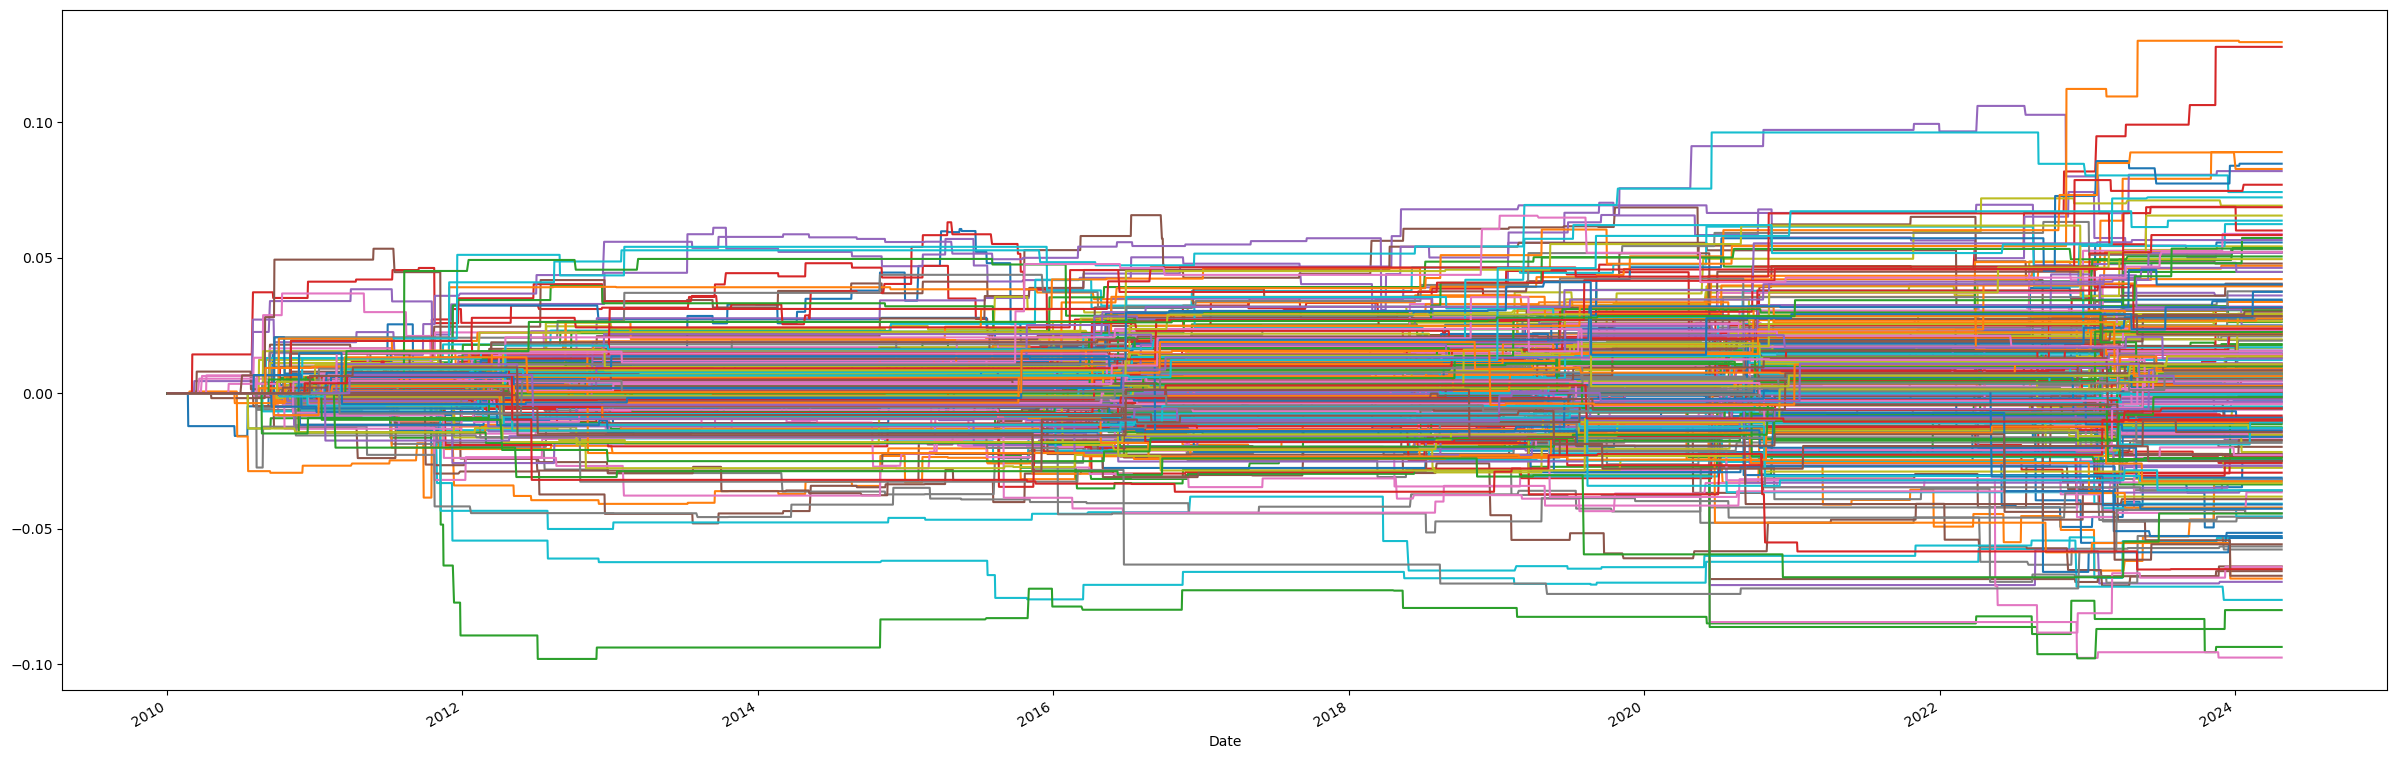

In [7]:
pf.cumulative_returns().plot(figsize=(30, 10), legend= False)

In [8]:
 pf.total_return().vbt.heatmap().show()

The vbt library has an option to show a heatmap of the best combinations of the parameters. Using this I can visually identify clusters of good parameters - the parameters that provide positive returns. The output graph shows the moving average windows (parameters) that yield best performance, seen in light yellow. The fast window = 10 and slow = 50 seems to produce above 10% returns, and additionally fast=100 and slow=110 seems to produce similar results. No obvious clusters can be determined by visually inspecting this heatmap. However, it gives a rough idea of what to expect when using this simple approach.

In [31]:
#Following this I split the parameters to only keep those that are above 0. I then return the index of these best parameters. 
EXPECTED_RETURNS = 0
returns = pd.DataFrame(pf.total_return())
best_params = returns[returns['total_return'] > EXPECTED_RETURNS].index

# Part 3.2 DMAC backtesting

Next, I run a backtesting strategy using different parameter combinations of best_params. Then, I assign these signals to a DataFrame column named 'signal'. Additionally, generating exit signals based on the previous entry signals and calculating the price change for each period to determine the target variable ('y'). Finally, I output the columns related to moving average signals (cols) and the distribution of generated signals. I describe each step in detail below:


1. Signal Generation: For each parameter combination in best_params, I calculate the fast and slow moving averages (fast and slow). I then generate entry signals when the fast moving average crosses above the slow moving average (entries). These signals are stored in columns named according to the parameter combination (ma_{i[0]}_{i[1]}). The overall signal ('signal') is updated to True whenever any of the moving average crossover signals are True.

2. Exit Signal Generation: Exit signals ('exit') are generated based on the previous period's entry signal. If the entry signal was True in the previous period, the exit signal is set to True in the current period.

3. Target Variable Calculation: The target variable ('y') is calculated as the sign of the percentage change in the closing price shifted by one period. This indicates whether the price will increase (1), decrease (-1), or stay the same (0) in the next period.

4. Printing Information: print the columns related to moving average signals (cols) and the distribution of generated signals ('signal').

In [32]:
#I create a loop to run a backtest. I create a fast MA and slow MA. And then calculate the entries based on the best_parameters.
#I then create the entries with these columns. 

data = Data_SPY.copy()
#Column placeholder for signal
data['signal'] = False

#Loop through each set of best parameters
for i in best_params:
    #Calculate fast and slow moving averages based on current parameters
    fast = vbt.MA.run(data['Close'], i[0], short_name='fast')
    slow = vbt.MA.run(data['Close'], i[1], short_name='slow')
    
    #Generate entry signals based on the current combination of moving averages
    entries = fast.ma_crossed_above(slow)
    
    #Create a column in the data DataFrame to store the entry signals for the current parameters
    data[f'ma_{i[0]}_{i[1]}'] = entries
    
    #Update the 'signal' column: if entry signal is True, set 'signal' to True
    data['signal'] = np.where(
        data[f'ma_{i[0]}_{i[1]}'] == True,
        True,
        data['signal']
    )

#Generate exit signals: set 'exit' to True if 'signal' was True in the previous period
data['exit'] = np.where(data['signal'].shift(1) == True, True, False)

#Calculate the future returns ('y') based on the next period's Close prices
data['y'] = np.sign(data['Close'].pct_change().shift(-1))

#Filter and print the columns containing 'ma' in their names
cols = data.filter(like='ma').columns
print(cols)

#Print the proportion of True values in the 'signal' column
print(data['signal'].value_counts(True))


Index(['ma_10_40', 'ma_10_50', 'ma_10_60', 'ma_10_70', 'ma_10_90', 'ma_10_100',
       'ma_10_120', 'ma_10_130', 'ma_10_150', 'ma_10_160',
       ...
       'ma_190_230', 'ma_190_240', 'ma_200_210', 'ma_200_220', 'ma_200_230',
       'ma_200_240', 'ma_210_220', 'ma_210_230', 'ma_210_240', 'ma_220_240'],
      dtype='object', length=155)
signal
False    0.676569
True     0.323431
Name: proportion, dtype: float64


The above information shows the proportion of True and False values in the 'signal' column. In this case, it indicates that approximately 68% of the signals are False, while about 32% are True. This suggests that the majority of periods do not trigger a trading signal based on the moving average crossovers. Therefore 68% of the signals do not have much predictive power. 

Subsequently I construct a trading strategy based on the signals with predictive power (the 32% of the parameters), forming a portfolio. And report this portfolios performance below. 

In [11]:
pf_best_params = vbt.Portfolio.from_signals(
    data['Close'],
    data['signal'],
    data['exit']
)
pf_best_params.plot(height=400, width=1300).show()

In [12]:
pf_best_params.stats()

Start                         2010-01-04 00:00:00
End                           2024-04-25 00:00:00
Period                                       3602
Start Value                                 100.0
End Value                              809.237447
Total Return [%]                       709.237447
Benchmark Return [%]                   344.268933
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                         8.430541
Max Drawdown Duration                       146.0
Total Trades                                  499
Total Closed Trades                           499
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            64.529058
Best Trade [%]                           5.139524
Worst Trade [%]                         -6.846525
Avg Winning Trade [%]                    1.075706
Avg Losing Trade [%]                    -0.762154


In [13]:
#I inspect the signal data column Y
data['y']

Date
2010-01-04    1.0
2010-01-05    1.0
2010-01-06    1.0
2010-01-07    1.0
2010-01-08    1.0
             ... 
2024-04-19    1.0
2024-04-22    1.0
2024-04-23   -1.0
2024-04-24   -1.0
2024-04-25    NaN
Name: y, Length: 3602, dtype: float64

In [14]:
#I remove the NaN value (last)
data.dropna(subset=['y'], inplace=True)
data['y']

Date
2010-01-04    1.0
2010-01-05    1.0
2010-01-06    1.0
2010-01-07    1.0
2010-01-08    1.0
             ... 
2024-04-18   -1.0
2024-04-19    1.0
2024-04-22    1.0
2024-04-23   -1.0
2024-04-24   -1.0
Name: y, Length: 3601, dtype: float64

As it can be seen in the graph above this backtesting strategy outperforms the benchmark by quite a margin. Almost 2x higher returns when compared to the benchmark when using the whole holding period returns. There is also a quite high number of trades reported in this strategy, and trading costs are not included.

What does this tell me? : the strategy performs very well in-sample and this could be due to overfitting. These results would be hard to replicate in real life due to trading costs, and many more limits. Therefore it is crucial to test this performance out-of-sample, and test if the parameters currently chosen are indeed the correct ones as right now I have no bearing. 

To solve this issues I next train a machine learning model by splitting the data into train and model, and perform out-of-sample tests. The model in question forms predictions using random forest classifier machine learning using the trading signals created previously. 

# Part 3.3 Model training based on moving average paramaters

Using train_test_split to split your data into training and testing sets. I set my shuffle input to False, which means the data won't be shuffled before splitting. This is because I want to maintain the time-series nature of the returns. If I set it to true the observations will not maintain the time series order. This ensures that the inherit order is maintained. More information can be found below:

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

test_size=0.2 means that 20% of the data is used for testing, and 80% to train the model. 

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data[cols], data['y'], test_size=0.2, shuffle=False)

The model I choose in this case is a random forest classifier. It is a supervised machine learning algorithm used to classify the data, therefore the outcome will be false or true to a set question. Random forests use ensamble methods: they combine different methodologies from other models to arrive at an prediction. With each smaller model in a random forest being a decision tree. Predictions are made for each decision tree, then the most popular trees are taken.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [16]:
#Initialize the Random Forest classifier
model = RandomForestClassifier()

#Train the model
model.fit(X_train, y_train)

#Make predictions on the test set
predictions = model.predict(X_test)

#Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.49514563106796117


The model is initialized, train on the data, lastly the model makes predictions. Currently around 50% of the parameters are useful in the predictions. Therefore the other half has no predictive power based on this model. 

Next I assign predictive score to each parameter (the combination of Moving average windows). This will answer the question of which paremeters have the most predictive power and then select those parameters to optimize the moving average strategy. 

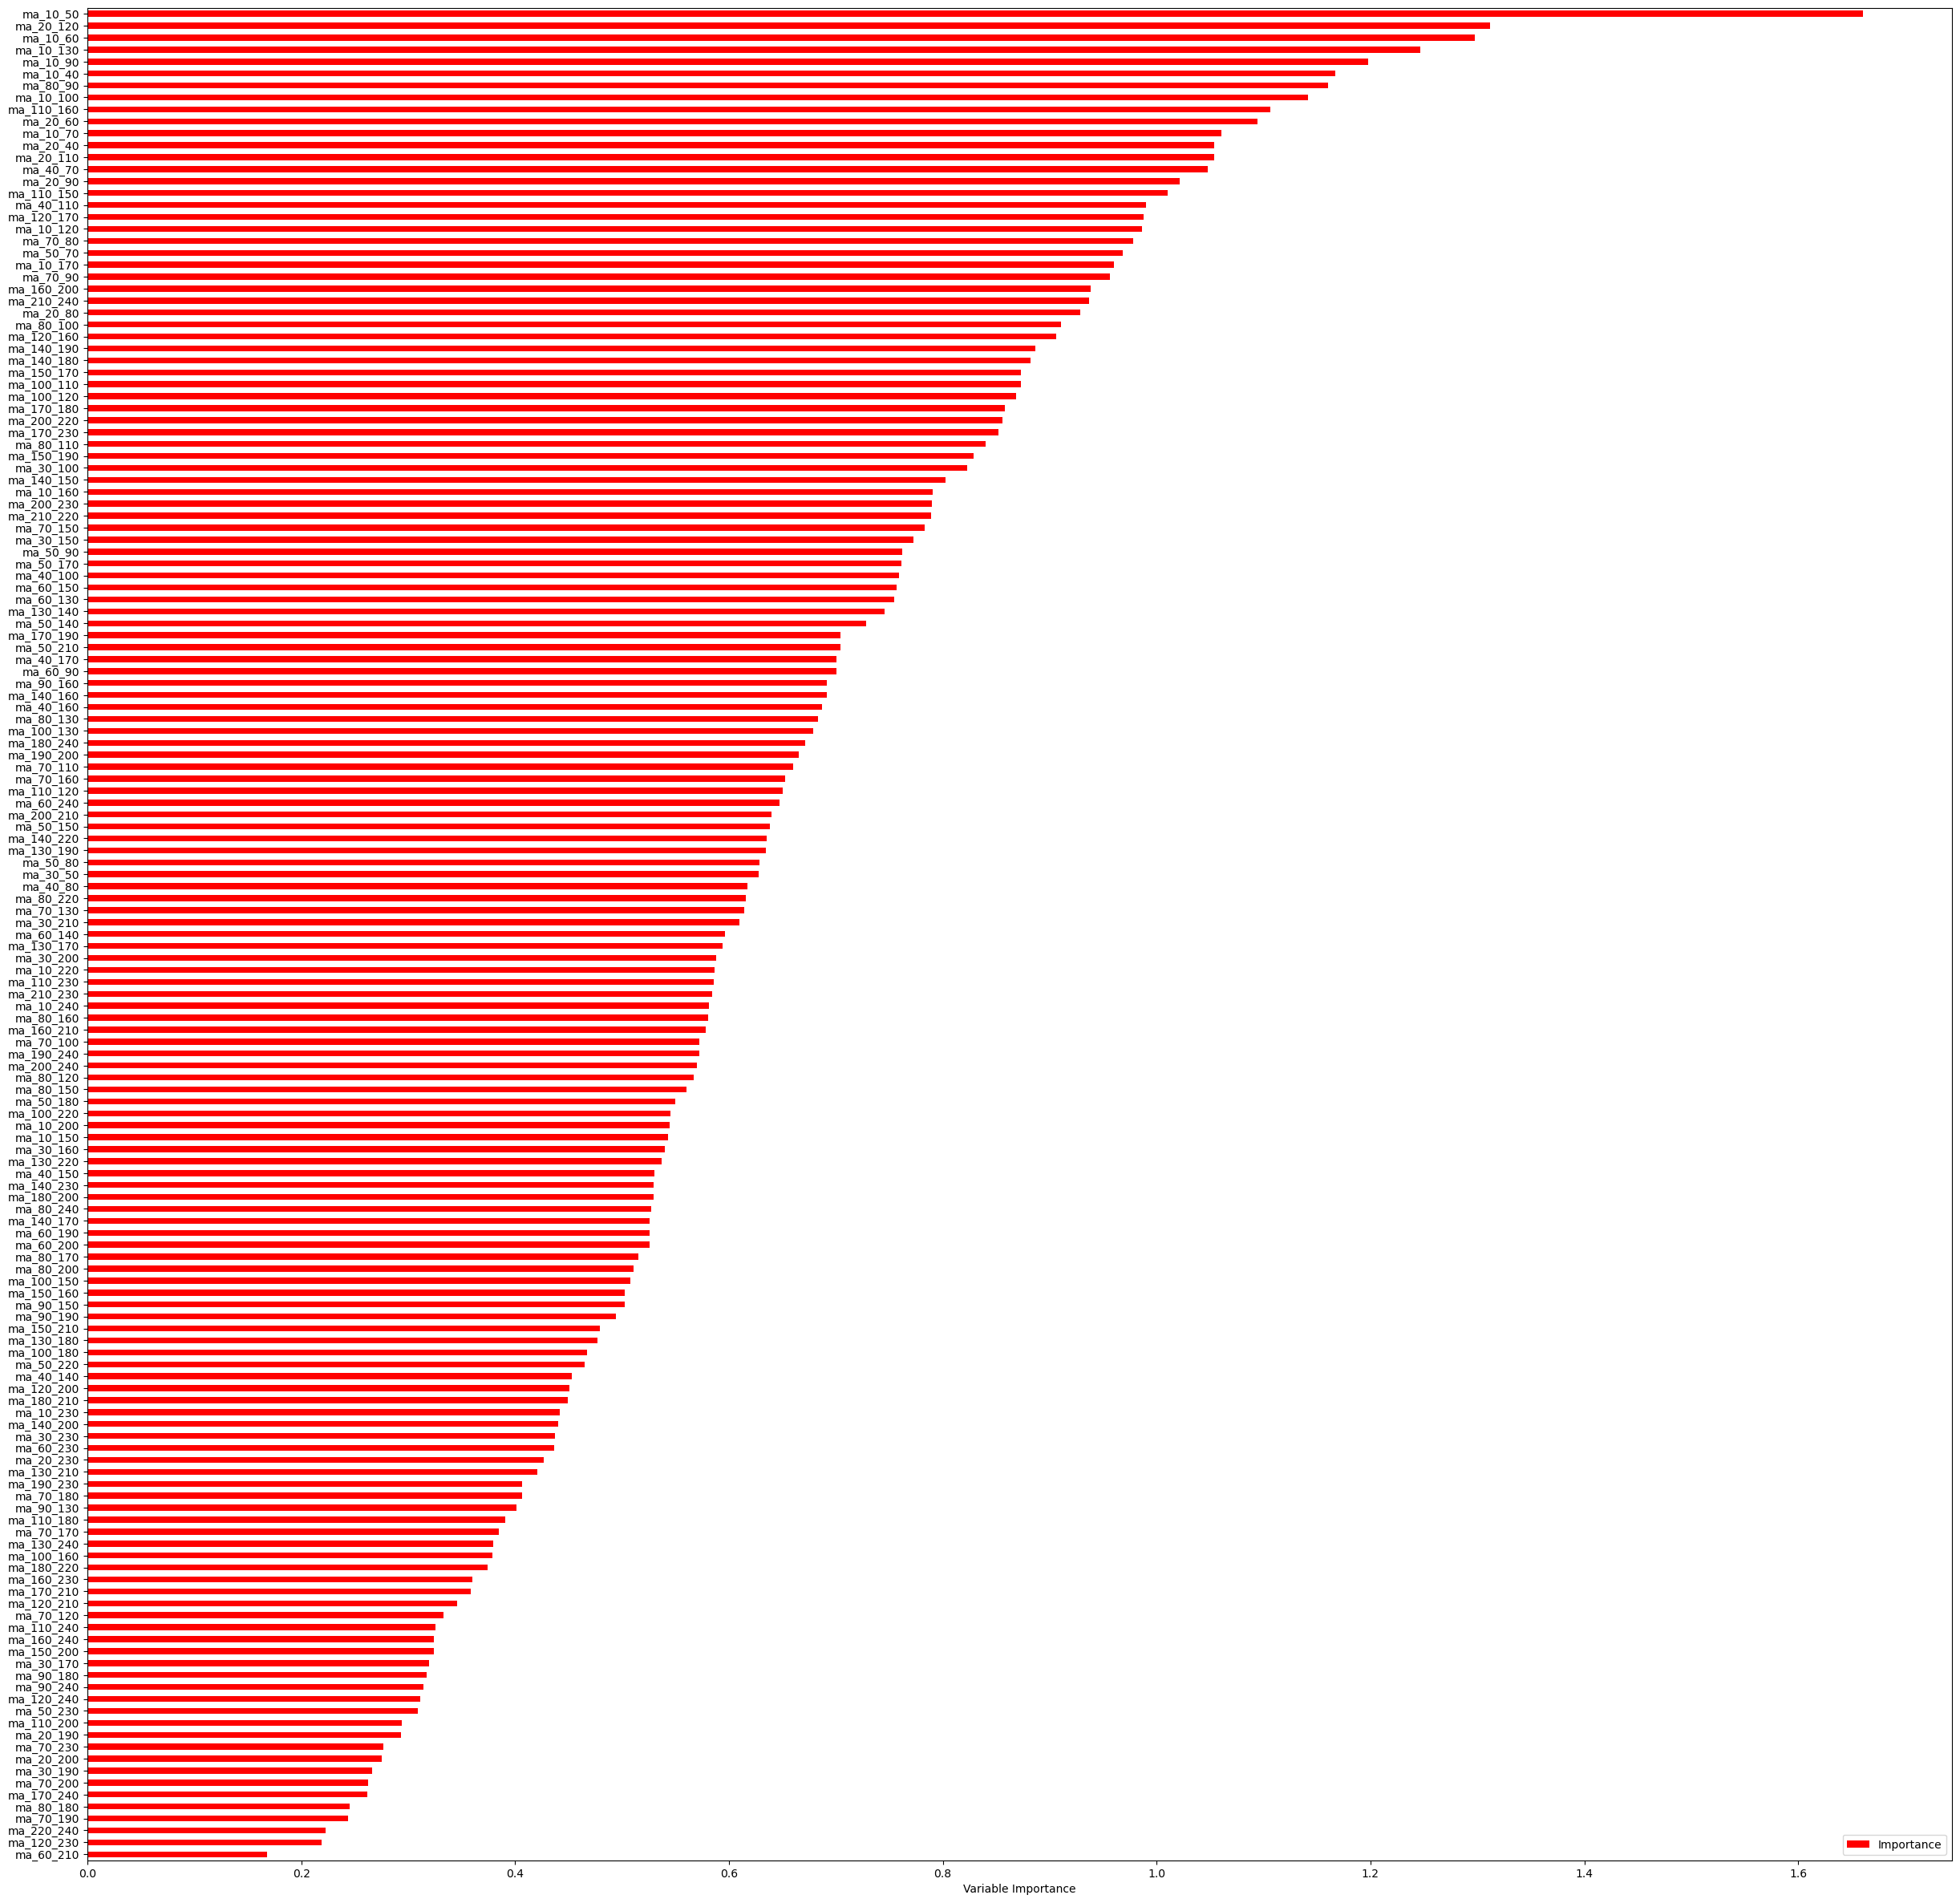

Len: 155


In [17]:
#Create DataFrame for feature importances
importance = pd.DataFrame({'Importance': model.feature_importances_ * 100}, index=X_train.columns)

#Sort the DataFrame by importance in ascending order and plot as a horizontal bar plot
importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', figsize=(30, 30))
plt.xlabel('Variable Importance')
plt.show()  #Show the plot
print('Len:', len(importance))  #print the length of the importance DataFrame

Few observations stand out, moving average windows combinations of short and long seem to have the best predicive power. the two best seem to be around 10_50, 10_60. Then the next two parameters are 10_130, 10_120. So it seems that the best performing parameters score somewhere around these two clusers. The worst perfoming parameters seem to have x_200+ on visual inspection. It is therefore useful to exclude some parameters to obtain a better performing model. 

In [18]:
LEN = 95  #I keep 95 of top parameters to select

#Sort features by importance and select the top LEN features
top_ma = importance.sort_values(by=['Importance'], ascending=False).head(LEN)

I take 95 best moving average parameters. 

In [19]:
#Selecting test data based on the indices of the test set
test = data.loc[X_test.index, :]

#Initializing a new column 'signal' in the test DataFrame and setting all values to False
test['signal'] = False

#Iterating over the indices of the top features DataFrame (top_ma)
for i in top_ma.index:
    # Splitting the index string to extract the parameters of the top feature
    i = i.split('_')[1:]
    
    #Generating trading signals based on the condition specified by the top feature
    #If the condition is met for a particular row in the test data, set the corresponding 'signal' value to True
    test['signal'] = np.where(
        test[f'ma_{i[0]}_{i[1]}'] == True,  #Condition based on the top feature parameters
        True,  #Set 'signal' to True if the condition is met
        test['signal']  #Otherwise, keep the existing 'signal' value
    )

#Generating exit signals ('exit') based on the previous period's entry signal ('signal')
#If the entry signal was True in the previous period, set the exit signal to True in the current period
test['exit'] = np.where(test['signal'].shift(1) == True, True, False)

#Printing the distribution of the generated signals in the test dataset
print(test['signal'].value_counts(True))

signal
False    0.718447
True     0.281553
Name: proportion, dtype: float64


I repeat the code for the DMAC strategy as previously, this time using the data provided by the random forest classifier. 

For this strategy the signals generated suggest that for 72% of the time the signal is False, this means that no trade/position is active. And around 27% of the time we are either long or short a position (trading signal is generated). I subsequently form a portfolio based on the signals from this strategy and reports it's performance. I include a fee of 0.001 point per trade to reflect some of the market frictions, this number can differ per the investor/country but this is my best estimate as I expect that trading this security with long positions will not be costly. Taking short positions however can be a costly endevour, but I did not include the costs in the model, and hopefully it is already captured by high trading fees of 0.001 or 0.1% per trade. 

In [20]:
pf = vbt.Portfolio.from_signals(
    test['Close'], 
    test['signal'],  
    test['exit'], 
    fees=0.001
)

#Plot the performance of the portfolio
pf.plot(height=400, width=900).show()

In [21]:
test

Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-06-14  424.429993  425.369995  423.100006  425.260010  404.303497   
2021-06-15  425.420013  425.459991  423.540009  424.480011  403.561920   
2021-06-16  424.630005  424.869995  419.920013  422.109985  401.308716   
2021-06-17  421.670013  423.019989  419.320007  421.970001  401.175537   
2021-06-18  417.089996  417.829987  414.700012  414.920013  395.763580   
...                ...         ...         ...         ...         ...   
2024-04-18  501.980011  504.130005  498.559998  499.519989  496.391113   
2024-04-19  499.440002  500.459991  493.859985  495.160004  492.058411   
2024-04-22  497.829987  502.380005  495.429993  499.720001  496.589844   
2024-04-23  501.779999  506.089996  499.529999  505.649994  502.482697   
2024-04-24  506.559998  507.369995  503.130005  505.410004  502.244202   

               Volume  signal  ma_10_40  ma_10_50  ma_10_60  ...  ma_200_210  \
Date                                                         ...               
2021-06-14   42358500   False     False     False     False  ...       False   
2021-06-15   51508500   False     False     False     False  ...       False   
2021-06-16   80386100   False     False     False     False  ...       False   
2021-06-17   90949700   False     False     False     False  ...       False   
2021-06-18  118676300   False     False     False     False  ...       False   
...               ...     ...       ...       ...       ...  ...         ...   
2024-04-18   74548100   False     False     False     False  ...       False   
2024-04-19  102129100   False     False     False     False  ...       False   
2024-04-22   67961000   False     False     False     False  ...       False   
2024-04-23   64633600   False     False     False     False  ...       False   
2024-04-24   55928100   False     False     False     False  ...       False   

            ma_200_220  ma_200_230  ma_200_240  ma_210_220  ma_210_230  \
Date                                                                     
2021-06-14       False       False       False       False       False   
2021-06-15       False       False       False       False       False   
2021-06-16       False       False       False       False       False   
2021-06-17       False       False       False       False       False   
2021-06-18       False       False       False       False       False   
...                ...         ...         ...         ...         ...   
2024-04-18       False       False       False       False       False   
2024-04-19       False       False       False       False       False   
2024-04-22       False       False       False       False       False   
2024-04-23       False       False       False       False       False   
2024-04-24       False       False       False       False       False   

            ma_210_240  ma_220_240   exit    y  
Date                                            
2021-06-14       False       False  False -1.0  
2021-06-15       False       False  False -1.0  
2021-06-16       False       False  False -1.0  
2021-06-17       False       False  False -1.0  
2021-06-18       False       False  False  1.0  
...                ...         ...    ...  ...  
2024-04-18       False       False  False -1.0  
2024-04-19       False       False  False  1.0  
2024-04-22       False       False  False  1.0  
2024-04-23       False       False  False -1.0  
2024-04-24       False       False  False -1.0  

[721 rows x 164 columns]

In [22]:
pf.stats()

Start                         2021-06-14 00:00:00
End                           2024-04-24 00:00:00
Period                                        721
Start Value                                 100.0
End Value                              133.443449
Total Return [%]                        33.443449
Benchmark Return [%]                    18.847292
Max Gross Exposure [%]                      100.0
Total Fees Paid                         20.742346
Max Drawdown [%]                         9.160175
Max Drawdown Duration                       145.0
Total Trades                                   89
Total Closed Trades                            89
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            59.550562
Best Trade [%]                           3.842062
Worst Trade [%]                         -4.249073
Avg Winning Trade [%]                    1.160203
Avg Losing Trade [%]                    -0.879775


# Part 4 Performance

First point that stands out about this strategy is that the time-series data starts at around June 2021 even though the training data set started in 2010 through to 2024. Yet the first trade using the ML approach described above only takes place on october 15, 2021. As such the strategy provided no signals for 11 years!. This could be explained by the bull market that existed in those years and relative low volatility. Therefore the parameters did not generate credible signals. However when I plot the SPY returns over the time scale below. I find that the strategy didn't provide a signal during the march 2020 crash, or other significant crashes. 

Evaluation: Good

The performance for the period where the trades did take place is very good, 35% compared to the benchmark returns of 19%. This is the performance after paying around 19.75% of returns in fees!(85 trades total). The maximum loss of teh portfolio was 9% and the duration of this was 145 days, so the drawdawn is moderate to low. Hovewer it is worth noting that no significant market crash did occur during this period so this may be biased. 

Did it meet my expectations?

The performance is around 35-19= 16%, over 3-4 years that's around 4%ish excess return over the benchmark. This means that this meets the performance results reported in the similar research. By visually inspecting the graphs the strategy also seems to have lower volatility than the benchmark. All in line with previous research. 

The winrate repors around 62% of the bets being in-the-money, so the hit rate is exceptional. On average the trades seems to be proftable, suggesting that the strategy has some predictive power when tested out-of-sample. The best winner bet seems to be lower than worst winner bet:  3.8% vs -4.2%. However on average the winner outperforms the loser : 1.15% to -0.93%. The average duration of winning trades also seems to be higher than the average duration of losing trades 2.45 compared to 2.19. This suggests that the algorithm seems to overcome some behavioural biases humans may entail (holding onto the losers longer and dropping the winners faster). 

Evaluation: Bad

The model is sensitive to the time-frame of the price time-series provided. Adjusting the time-frame can have drastic change on the weighting of the performance of the parameters (using 2015 data - 2024 to train the model). For example a 100 to 120 MA parameter may now have the highest predictive power instead of the 10 to 50. In that case the results of the portfolio can underperform the benchmark. In general, the model is not reliable and the selection of the data frame is most crucial. This variability in the data's time frame does not inspire confidence in believing this strategys returns. It is impossible to tell which time frame to select, and if the selected time frame will continue to cause superior performance. 

Another point to note is that there are periods where the strategy is not invested at all as no signals are generated. In these periods the benchmark can outperform during bull markets. As such this strategy would involve evaluating several (hundreds) securities and ranking them based on the confidence of predictions. This would provide sufficient investing oppurtunities to avoid the fund not being invested in anything. For simplicity I only test one ETF, but this could be scaled to many more assets. 



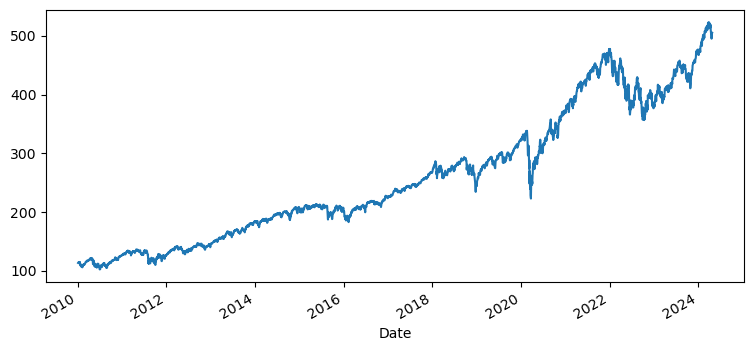

In [23]:
#Plotting only the SPY returns over the entire period
data['Close'].plot(figsize=(9, 4))  # Adjust the figsize as needed
plt.show()

End. 